# Business Problem 

# Data Cleaning

In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import punkt
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import recall_score, accuracy_score

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam, SGD

from wordcloud import WordCloud
from textwrap import wrap
from textblob import TextBlob
import gensim
from gensim.models import Word2Vec

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
pd.set_option('display.max_columns', 1000)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
% matplotlib inline

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/MichaelWirtz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/MichaelWirtz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/MichaelWirtz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
UsageError: Line magic function `%` not found.


In [2]:
data = pd.read_csv('tweets_2.csv')

In [3]:
data.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


In [4]:
data.isna().sum()

id             0
keyword        0
location    3418
text           0
target         0
dtype: int64

#  Exploratory Data Analysis

## Reclassifying Disaster as Event / Non-Event

In [5]:
data.head(20)

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0
5,5,ablaze,OC,"If this child was Chinese, this tweet would ha...",0
6,6,ablaze,"London, England",Several houses have been set ablaze in Ngemsib...,1
7,7,ablaze,Bharat,Asansol: A BJP office in Salanpur village was ...,1
8,8,ablaze,"Accra, Ghana","National Security Minister, Kan Dapaah's side ...",0
9,9,ablaze,Searching,This creature who’s soul is no longer clarent ...,0


When going through the text data, we found that disaster is used incorrectly in classifying the tweets. We found that a better classification would more appropriately be either "Event" or "Non-Event." This is because we found many instances of positive "Disaster" classification when we believe the instance to not meet that definition. For example, many instances of thunderstorms were each classified as a "Disaster", while we believe that instances such as those would be better classified as an "Event."

## What should they search for?

### What's the Class Imbalance?

Text(0, 0.5, 'Percentage')

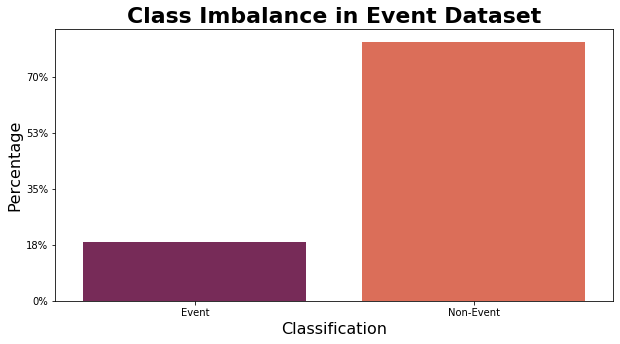

In [6]:
class_imbalance = [len(data[data.target == 1]), len(data[data.target == 0])]
classes = ['Event','Non-Event']

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(classes, class_imbalance, ax = ax, palette='rocket')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(11370))
plt.title('Class Imbalance in Event Dataset', fontsize=22, fontweight='bold')
plt.xlabel('Classification', fontsize=16)
plt.ylabel('Percentage', fontsize=16)

### Most Common Keywords that were Real Events

In [7]:
# data[data.target == 1]['keyword'].value_counts().head(10).plot(kind = 'bar')
keyword_real = pd.DataFrame(data[data.target == 1]['keyword'].value_counts().head(10))
keyword_real.reset_index(inplace=True)
keyword_real.columns = ['keyword','frequency']
keyword_real.keyword = keyword_real.keyword.apply(lambda x: x.split('%20'))
keyword_real.keyword = keyword_real.keyword.apply(lambda x: ','.join(x))
keyword_real.keyword = keyword_real.keyword.apply(lambda x: x.replace(',',' '))
keyword_real.keyword = keyword_real.keyword.apply(lambda x: x.title())


Text(0.5, 0, 'Frequency')

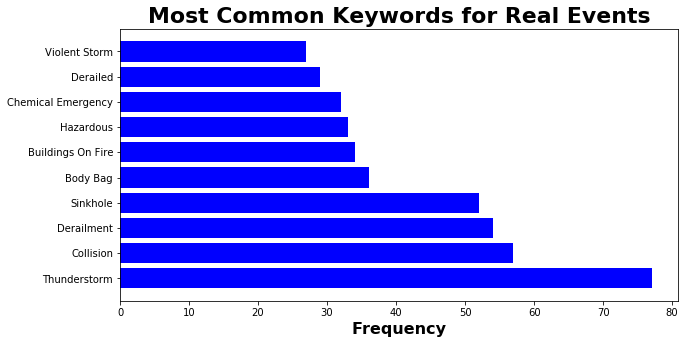

In [8]:
plt.figure(figsize=(10,5))
plt.barh(keyword_real.keyword, keyword_real.frequency, color='blue')
plt.title('Most Common Keywords for Real Events', fontsize=22, fontweight='bold')
plt.xlabel('Frequency', fontsize=16, fontweight='bold')

### Most Common Keywords that were Not Event Related

In [9]:
keyword_not = pd.DataFrame(data[data.target == 0]['keyword'].value_counts().head(10))
keyword_not.reset_index(inplace=True)
keyword_not.columns = ['keyword','frequency']
keyword_not.keyword = keyword_not.keyword.apply(lambda x: x.split('%20'))
keyword_not.keyword = keyword_not.keyword.apply(lambda x: ','.join(x))
keyword_not.keyword = keyword_not.keyword.apply(lambda x: x.replace(',',' '))
keyword_not.keyword = keyword_not.keyword.apply(lambda x: x.title())

Text(0.5, 0, 'Frequency')

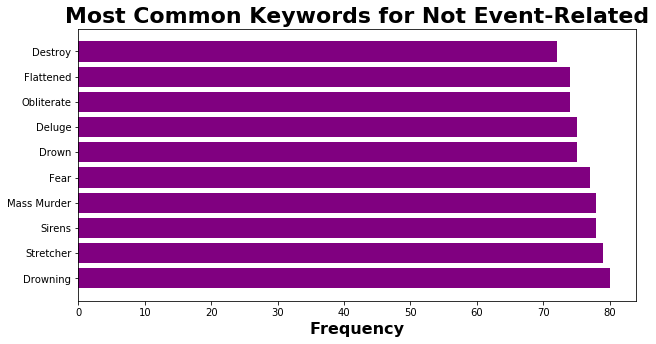

In [10]:
plt.figure(figsize=(10,5))
plt.barh(keyword_not.keyword, keyword_not.frequency, color='purple')
plt.title('Most Common Keywords for Not Event-Related', fontsize=22, fontweight='bold')
plt.xlabel('Frequency', fontsize=16, fontweight='bold')

### Where are our Tweets Coming From?

In [11]:
data.location.replace(['California, USA', 'Los Angeles, CA', 'United States'], 'USA', inplace= True)
data.location.replace(['Lagos, Nigeria'], 'Nigeria', inplace= True)
data.location.replace(['England, United Kingdom','United Kingdom'], 'UK', inplace= True)
data.location.replace(['Earth'], 'Unknown', inplace= True)


Text(0.5, 0, 'Frequency')

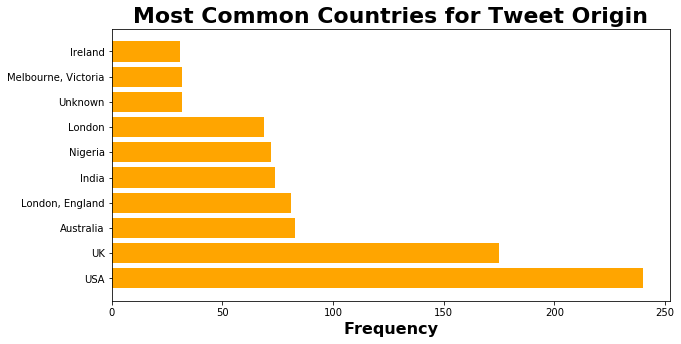

In [12]:
location = pd.DataFrame(data.location.value_counts().head(10))

plt.figure(figsize=(10,5))
plt.barh(location.index, location.location, color='orange')
plt.title('Most Common Countries for Tweet Origin', fontsize=22, fontweight='bold')
plt.xlabel('Frequency', fontsize=16, fontweight='bold')

### Was Sentiment Different Btw the Positive and Negative Classes?

#### Polarity

In [14]:
data['polarity_score'] = data['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [16]:
positive = data[data.target == 1]
negative = data[data.target == 0]
perc_pos = round((len(positive[positive.polarity_score < 0]) / len(positive)), 3)
perc_neg = round((len(negative[negative.polarity_score < 0]) / len(negative)), 3)
print('{}% of the disaster data has negative polarity'.format(perc_pos))
print('{}% of the non-disaster data has negative polarity'.format(perc_neg))

0.299% of the disaster data has negative polarity
0.225% of the non-disaster data has negative polarity


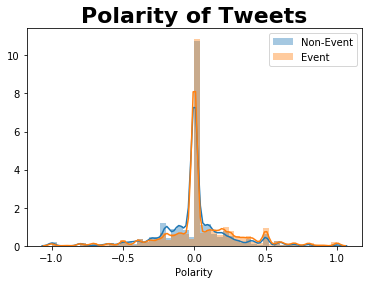

In [17]:
sns.distplot(positive.polarity_score, label='Non-Event')
sns.distplot(negative.polarity_score, label='Event')

plt.title('Polarity of Tweets', fontsize=22, fontweight='bold')
plt.xlabel('Polarity')
plt.legend()

#### Subjectivity

In [18]:
data['subjectivity_score'] = data['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

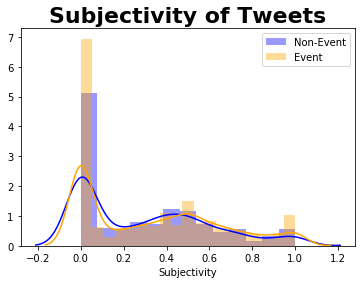

In [22]:
positive = data[data.target == 1]
negative = data[data.target == 0]
sns.distplot(positive.subjectivity_score, label='Non-Event', color='blue')
sns.distplot(negative.subjectivity_score, label='Event', color='orange')

plt.title('Subjectivity of Tweets', fontsize=22, fontweight='bold')
plt.xlabel('Subjectivity')
plt.legend()

### Does Tweet Length Make a Difference?

In [23]:
data['text_length'] = data['text'].apply(lambda x: len(x))

In [24]:
positive = data[data.target == 1]
negative = data[data.target == 0]

Text(0, 0.5, 'Median')

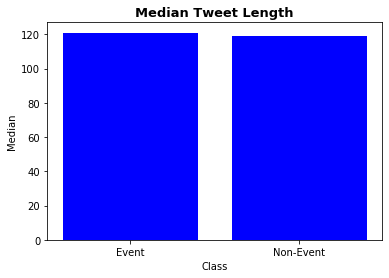

In [25]:
avg_length_pos = positive.text_length.median()
avg_length_neg = negative.text_length.median()
plt.bar(('Event','Non-Event'),(avg_length_pos, avg_length_neg), color='blue')
plt.title('Median Tweet Length', fontsize=13, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Median')

### Is there a Difference Btw Tweets with and without Hyperlinks?

In [26]:
data['hyperlink_present'] = data.text.apply(lambda x: 1 if 'https' in x else 0)

In [27]:
positive = data[data.target == 1]
negative = data[data.target == 0]

Text(0, 0.5, 'Hyperlink in Tweet Rate')

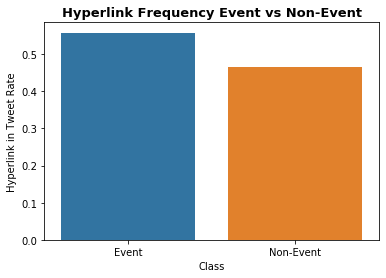

In [28]:
hyperlink_labels = ['Event','Non-Event']
hyperlink_frequencies = ((positive.hyperlink_present.sum() / len(positive)), 
                     (negative.hyperlink_present.sum() / len(negative)))

sns.barplot(hyperlink_labels, hyperlink_frequencies)
plt.title('Hyperlink Frequency Event vs Non-Event', fontsize=13, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Hyperlink in Tweet Rate')

### Difference Btw Tweets with and without Emojis?

In [29]:
emoji_df = data

In [31]:
tokenizer_emojis = RegexpTokenizer(r'[\U00010000-\U0010ffff]+')
emoji_df.text = emoji_df.text.apply(lambda x: tokenizer_emojis.tokenize(x))

In [33]:
emoji_df['emojies_score'] = emoji_df.text.apply(lambda x: 1 if len(x) > 1 else 0)

In [34]:
positive_emojis = emoji_df[emoji_df.target == 1]
negative_emojis = emoji_df[emoji_df.target == 0]

emoji_labels = ['Event','Non-Event']
emoji_frequencies = ((positive_emojis.emojies_score.sum() / len(positive_emojis)), 
                     (negative_emojis.emojies_score.sum() / len(negative_emojis)))

Text(0, 0.5, 'Emoji in Tweet Rate')

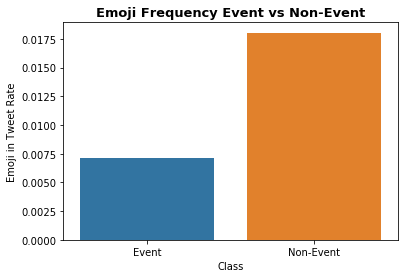

In [35]:
sns.barplot(emoji_labels, emoji_frequencies)
plt.title('Emoji Frequency Event vs Non-Event', fontsize=13, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Emoji in Tweet Rate')

### Most Common Unigram Search Result Words for Real Events

In [12]:
cloud = data
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
cloud.text = cloud.text.apply(lambda x: tokenizer.tokenize(x))

In [13]:
def lower_token(word_list):
    lowered_tokenized = []
    for x in word_list:
        x = x.lower()
        lowered_tokenized.append(x)
    return lowered_tokenized

cloud.text = cloud.text.apply(lambda x: lower_token(x))

In [14]:
stopword_given = stopwords.words('english')
more_stopwords = ['co','amp','say','want','really','many','let','see','said','got','day','https','c','w','still','go','u','new','one','b','know','two','make','people','us','think','h','time','g','another','p','l','today','th','n','e','v','x','j','z','f','always','good','thing','must','someone','even','much','guy','work','house','video','every','stop','remember','need','first','back','country','well','man','come','live','year','via','take','going','tell','next','q','place','says','days','made','news','world','hour','feel','bad','last','never','put','may','way','gon','na','au','gove']
stopwords_final = stopword_given + more_stopwords

In [15]:
def remove_stops(word_list):
    filtered = []
    for x in word_list:
        if x not in stopwords_final:
            filtered.append(x)
    return filtered

cloud.text = cloud.text.apply(lambda x: remove_stops(x))

In [16]:
cloud.text = cloud.text.apply(lambda x: ','.join(x))
cloud.text = cloud.text.apply(lambda x: x.replace(',',' '))

In [17]:
cloud_positive = cloud[cloud.target == 1]
text_positive = " ".join(review for review in cloud_positive.text)

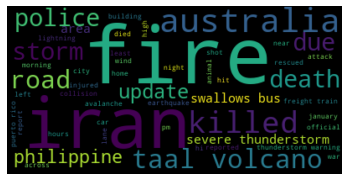

In [18]:
wordcloud_full = WordCloud(background_color="black", max_words = 50).generate(text_positive)

plt.imshow(wordcloud_full, interpolation='bilinear')
plt.axis("off")
plt.show()

### Most Common Unigram Search Result Words for Non Event-Related

In [19]:
cloud_negative = cloud[cloud.target == 0]

In [20]:
text_negative = " ".join(review for review in cloud_negative.text)

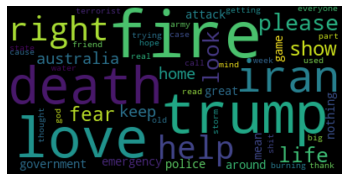

In [21]:
wordcloud_negative = WordCloud(background_color="black", max_words = 50).generate(text_negative)

plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.show()

### Most Common Unigram Search Result Words for Real Events

In [44]:
def wordcloud_creator_bigram(data, max_words = 50, stopwords=None):

    # Tokenize data
    nltk_tokens = nltk.word_tokenize(data)
    tokens_minus_stop = []
    for i in nltk_tokens:
        if i not in stopwords_final:
            tokens_minus_stop.append(i)
    # Create bigrams
    bigrams_list = list(nltk.bigrams(tokens_minus_stop))
    # Join bigrams
    bigrams = [' '.join(tup) for tup in bigrams_list]
    # Fit transform bigrams
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    bag_of_words = vectorizer.fit_transform(bigrams)
    # Get bigram counts
    sum_words = bag_of_words.sum(axis=0) 
    # Create fequency dictionary
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    # Sort frequency dictionary
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    # Reformat as dictionary
    words_dict = dict(words_freq)
    
    # Create wordcloud
    wordcloud = WordCloud(max_words=max_words, stopwords=None)
    wordcloud.generate_from_frequencies(words_dict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    
    return plt.show()

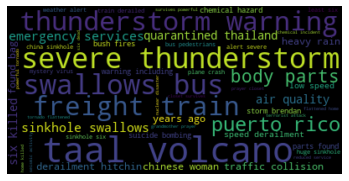

In [45]:
wordcloud_creator_bigram(text_positive)

### Most Common Bigram Search Result Words for Non Event-Related

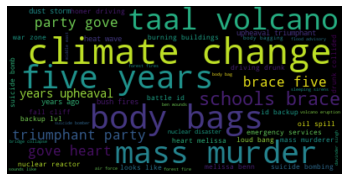

In [46]:
wordcloud_creator_bigram(text_negative)

### Most Similar Words for Real Event

In [47]:
vec_positive = data[data.target == 1]

In [48]:
tokenizer_vec_positive = RegexpTokenizer(r'[a-zA-Z]+')

vec_positive.text = vec_positive.text.apply(lambda x: tokenizer_vec_positive.tokenize(x))



/Users/MichaelWirtz/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [49]:
vec_positive.text = vec_positive.text.apply(lambda x: remove_stops(x))

In [50]:
vec_positive_list = []

for sentence in vec_positive.text:
    vec_positive_list.append(sentence)

In [51]:
model_positive = gensim.models.Word2Vec(vec_positive_list, size=32)

In [52]:
model_positive.most_similar('ablaze')

/Users/MichaelWirtz/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('chinese', 0.744003176689148),
 ('bomb', 0.7393798232078552),
 ('six', 0.7323065400123596),
 ('sunday', 0.7167113423347473),
 ('huge', 0.7138049602508545),
 ('shot', 0.71214759349823),
 ('epicentre', 0.7102357745170593),
 ('passengers', 0.708964467048645),
 ('continue', 0.7049682140350342),
 ('chemical', 0.7004733085632324)]

### Most Similar Words for Non Event-Related

In [53]:
vec_negative = data[data.target == 0]

In [54]:
tokenizer_vec_negative = RegexpTokenizer(r'[a-zA-Z]+')

vec_negative.text = vec_negative.text.apply(lambda x: tokenizer_vec_negative.tokenize(x))


In [55]:
vec_negative.text = vec_negative.text.apply(lambda x: remove_stops(x))


In [56]:
vec_negative_list = []

for sentence in vec_negative.text:
    vec_negative_list.append(sentence)

In [57]:
model_negative = gensim.models.Word2Vec(vec_negative_list, size=32)

In [58]:
model_negative.most_similar('ablaze')

/Users/MichaelWirtz/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('success', 0.9765377044677734),
 ('member', 0.9618621468544006),
 ('happen', 0.9570381045341492),
 ('learning', 0.9562481045722961),
 ('epicentre', 0.9562346339225769),
 ('sea', 0.9557686448097229),
 ('signed', 0.955044686794281),
 ('ordered', 0.9545543193817139),
 ('fan', 0.9535951018333435),
 ('common', 0.953362226486206)]

# Feature engineering

In [102]:
# class imbalance, how we reclassified disaster into event/non-event